<a href="https://colab.research.google.com/github/avbarbaros/hu-invariant-moments/blob/main/lena_hu_moments_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👩 Case Study: Hu Moments with the Famous Lena Image

This notebook demonstrates the practical application of Hu invariant moments using the iconic **Lena image** - one of the most widely used test images in image processing since 1973.

## Learning Objectives:
1. Apply Hu moments to complex, real-world images (not just simple shapes)
2. Understand preprocessing importance for moment computation
3. Verify RST (Rotation-Scale-Translation) invariance on natural images
4. Build a practical image matching system using Hu moments
5. Analyze regional shape characteristics

---

In [33]:
# Required imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate, rescale
from skimage.draw import disk, polygon, ellipse
import urllib.request
from PIL import Image
import io
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [46]:
# Utility functions for Hu moments

def compute_hu_moments_opencv(image):
    """Compute Hu moments using OpenCV."""
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8) if image.max() <= 1 else image.astype(np.uint8)
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments)
    return hu_moments.flatten() # convert the 2D array into a 1D array


def log_transform_hu_moments(hu_moments):
    """
    Apply log transformation for better comparison.
    Hu moments span many orders of magnitude (10^-30 to 10^1).
    """
    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10) # preserving the signs of moments
    # return hu_moments

def create_shape(shape_type, size=100):
    """Create simple geometric shapes for comparison."""
    image = np.zeros((size, size), dtype=np.float64)
    center = size // 2

    if shape_type == 'circle':
        rr, cc = disk((center, center), size//4, shape=image.shape)
        image[rr, cc] = 1.0
    elif shape_type == 'triangle':
        r = size // 3
        rows = [center - r, center + r, center + r]
        cols = [center, center - r, center + r]
        rr, cc = polygon(rows, cols, shape=image.shape)
        image[rr, cc] = 1.0
    elif shape_type == 'rectangle':
        image[center-size//6:center+size//6, center-size//4:center+size//4] = 1.0

    return image

print("✅ Utility functions defined!")

✅ Utility functions defined!


---
## 1. 📥 Loading the Lena Image

The Lena image is a standard test image in image processing. We'll load it from available sources or create a synthetic portrait as fallback.

In [47]:
def load_lena_image():
    """Load the Lena image from various sources."""

    # Try web sources
    urls = [
        "https://boofcv.org/images/f/fe/Original_lena512.jpg",
    ]

    for url in urls:
        try:
            with urllib.request.urlopen(url, timeout=5) as response:
                img_data = response.read()
                img = Image.open(io.BytesIO(img_data))
                img_array = np.array(img.convert('L'))
                print(f"✅ Loaded Lena image from web")
                return cv2.resize(img_array, (256, 256))
        except:
            continue

    # Fallback to synthetic portrait
    print("⚠️ Using synthetic portrait (Lena unavailable)")

# Load the image
lena_image = load_lena_image()
print(f"Image shape: {lena_image.shape}")
print(f"Pixel range: [{lena_image.min()}, {lena_image.max()}]")

✅ Loaded Lena image from web
Image shape: (256, 256)
Pixel range: [23, 239]


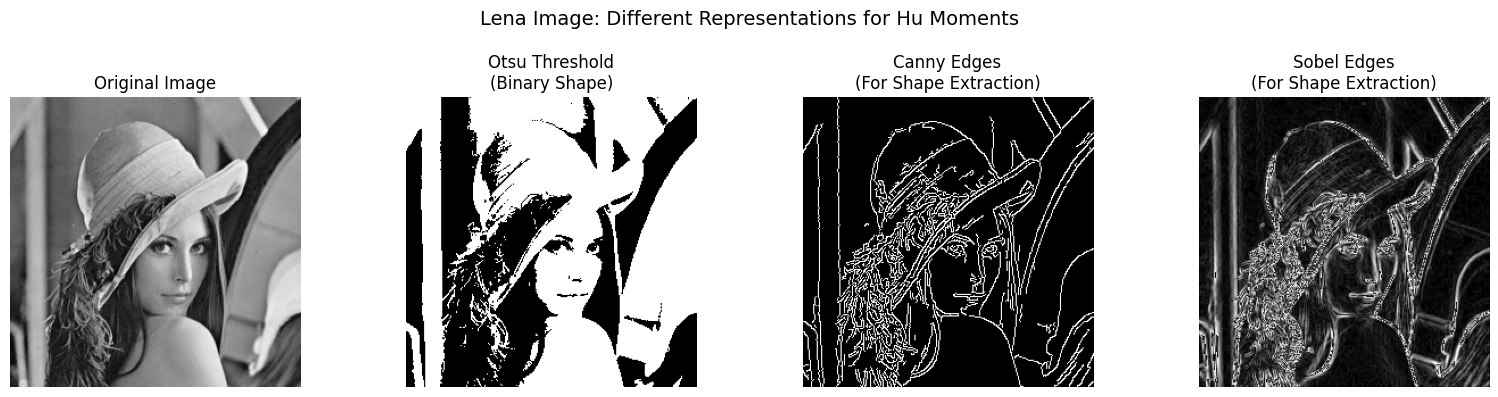

In [48]:
# Display the image with preprocessing options
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original
axes[0].imshow(lena_image, cmap='gray')
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

# Binary threshold (Otsu)
_, binary = cv2.threshold(lena_image.astype(np.uint8), 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
axes[1].imshow(binary, cmap='gray')
axes[1].set_title('Otsu Threshold\n(Binary Shape)', fontsize=12)
axes[1].axis('off')

# Canny Edge detection - Thinner (multi-staged, good at detecting thin,continues edges.)
edges = cv2.Canny(lena_image.astype(np.uint8), 50, 150)
axes[2].imshow(edges, cmap='gray')
axes[2].set_title('Canny Edges\n(For Shape Extraction)', fontsize=12)
axes[2].axis('off')

# Sobel edge detection - Thicker (gradient-based, sensitive to strong horizontal and vertical intensity changes.)
sobelx = cv2.Sobel(lena_image.astype(np.uint8), cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(lena_image.astype(np.uint8), cv2.CV_64F, 0, 1, ksize=3)
sobel = np.sqrt(sobelx**2 + sobely**2).astype(np.uint8)
axes[3].imshow(sobel, cmap='gray')
axes[3].set_title('Sobel Edges\n(For Shape Extraction)', fontsize=12)
axes[3].axis('off')

# Histogram
# axes[3].hist(lena_image.flatten(), bins=50, color='steelblue', alpha=0.7)
# axes[3].set_xlabel('Pixel Intensity')
# axes[3].set_ylabel('Frequency')
# axes[3].set_title('Intensity Histogram', fontsize=12)
# axes[3].grid(alpha=0.3)

plt.suptitle('Lena Image: Different Representations for Hu Moments\n', fontsize=14)
plt.tight_layout()
plt.show()

---
## 2. 🔬 Computing Hu Moments on Lena

Let's see how different preprocessing methods affect Hu moment computation.

**Key Insight:** Preprocessing choice matters! Edge detection captures shape, while raw grayscale includes intensity/texture information.

In [49]:
def compute_hu_for_variants(image):
    """Compute Hu moments for different preprocessing of the same image."""
    results = {}

    # Raw grayscale
    hu = compute_hu_moments_opencv(image)
    results['Raw Grayscale'] = log_transform_hu_moments(hu)

    # Binary (Otsu)
    _, binary = cv2.threshold(image.astype(np.uint8), 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    hu = compute_hu_moments_opencv(binary)
    results['Binary (Otsu)'] = log_transform_hu_moments(hu)

    # Canny edges
    edges = cv2.Canny(image.astype(np.uint8), 50, 150)
    hu = compute_hu_moments_opencv(edges)
    results['Canny Edges'] = log_transform_hu_moments(hu)

    # Sobel edges
    sobelx = cv2.Sobel(image.astype(np.uint8), cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image.astype(np.uint8), cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2).astype(np.uint8)
    hu = compute_hu_moments_opencv(sobel)
    results['Sobel Edges'] = log_transform_hu_moments(hu)

    return results


# Compute and display
hu_variants = compute_hu_for_variants(lena_image)

print("\n" + "="*85)
print("HU MOMENTS FOR LENA WITH DIFFERENT PREPROCESSING")
print("="*85)
print(f"\n{'Preprocessing':<18}", end="")
for i in range(7):
    print(f"{'φ'+str(i+1):<10}", end="")
print()
print("-" * 88)

for name, hu in hu_variants.items():
    print(f"{name:<18}", end="")
    for val in hu:
        print(f"{val:<10.4f}", end="")
    print()

print("\n💡 Key Insight: Different preprocessing → Different moment signatures!")
print("   • Edge methods capture shape structure")
print("   • Raw grayscale includes intensity distribution")


HU MOMENTS FOR LENA WITH DIFFERENT PREPROCESSING

Preprocessing     φ1        φ2        φ3        φ4        φ5        φ6        φ7        
----------------------------------------------------------------------------------------
Raw Grayscale     2.8764    8.1705    9.9950    9.9538    -10.0000  -10.0000  10.0000   
Binary (Otsu)     2.9691    7.9529    9.9873    9.8944    -10.0000  -10.0000  10.0000   
Canny Edges       2.4028    6.1762    9.0806    8.6396    -10.0000  9.9970    10.0000   
Sobel Edges       2.5500    6.8933    9.5255    9.3947    -10.0000  9.9995    -10.0000  

💡 Key Insight: Different preprocessing → Different moment signatures!
   • Edge methods capture shape structure
   • Raw grayscale includes intensity distribution


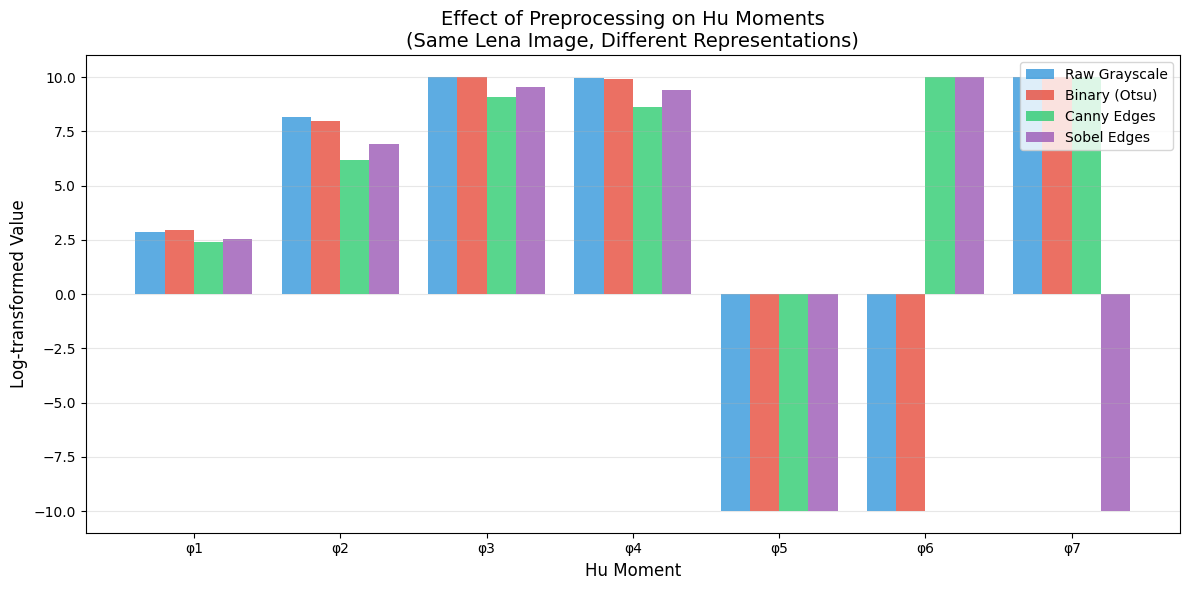

In [50]:
# Visualize the differences
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(7)
width = 0.2
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for i, (name, hu) in enumerate(hu_variants.items()):
    ax.bar(x + i*width, hu, width, label=name, color=colors[i], alpha=0.8)

ax.set_xlabel('Hu Moment', fontsize=12)
ax.set_ylabel('Log-transformed Value', fontsize=12)
ax.set_title('Effect of Preprocessing on Hu Moments\n(Same Lena Image, Different Representations)', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([f'φ{i+1}' for i in range(7)])
ax.legend(loc='upper right')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 3. 🔄 Testing RST Invariance on Lena

The power of Hu moments lies in their invariance to:
- **R**otation
- **S**cale
- **T**ranslation

Let's verify this on the Lena image!

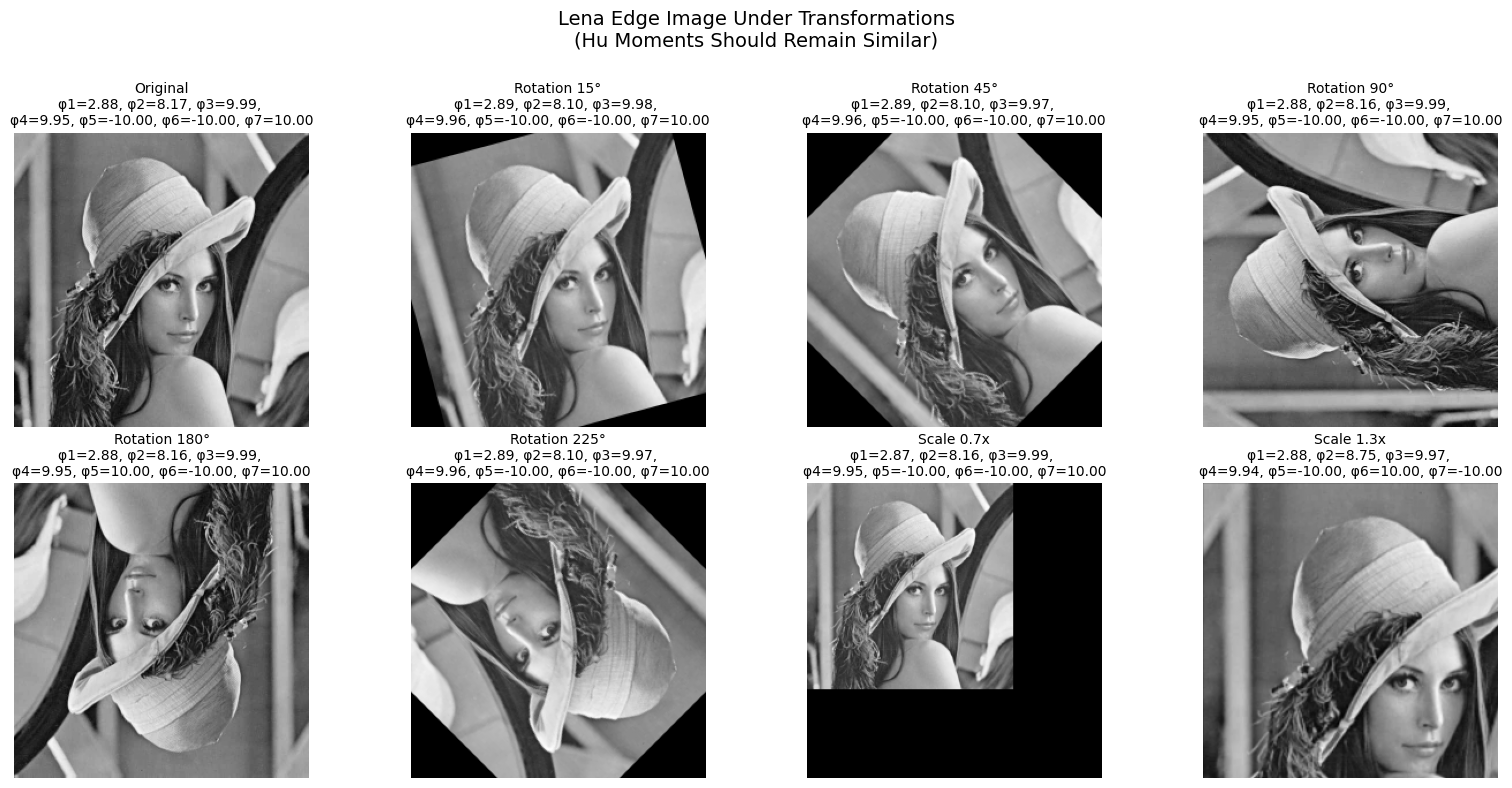

In [51]:
def test_invariance(image):
    """Apply various transformations to test Hu moment invariance."""

    edges = image

    # Use edge-detected version for cleaner analysis
    #edges = cv2.Canny(image.astype(np.uint8), 50, 150)


    transforms = {'Original': edges}

    # Rotations
    for angle in [15, 45, 90, 180, 225]:
        rotated = rotate(edges, angle, preserve_range=True, mode='constant')
        transforms[f'Rotation {angle}°'] = rotated

    # Scales
    for scale in [0.7, 1.3]:
        scaled = rescale(edges, scale, preserve_range=True, mode='constant')
        result = np.zeros_like(edges)
        h, w = min(scaled.shape[0], edges.shape[0]), min(scaled.shape[1], edges.shape[1])
        result[:h, :w] = scaled[:h, :w]
        transforms[f'Scale {scale}x'] = result

    return transforms


# Apply transformations
lena_transforms = test_invariance(lena_image)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

hu_results = {}
for ax, (name, img) in zip(axes, lena_transforms.items()):
    ax.imshow(img, cmap='gray')
    hu = log_transform_hu_moments(compute_hu_moments_opencv(img.astype(np.uint8)))
    hu_results[name] = hu
    ax.set_title(f'{name}\nφ1={hu[0]:.2f}, φ2={hu[1]:.2f}, φ3={hu[2]:.2f}, \nφ4={hu[3]:.2f}, φ5={hu[4]:.2f}, φ6={hu[5]:.2f}, φ7={hu[6]:.2f}', fontsize=10)
    ax.axis('off')

# Hide extra axes
for ax in axes[len(lena_transforms):]:
    ax.axis('off')

plt.suptitle('Lena Edge Image Under Transformations\n(Hu Moments Should Remain Similar)\n', fontsize=14)
plt.tight_layout()
plt.show()

In [52]:
# Quantify invariance
print("\n" + "="*70)
print("INVARIANCE ANALYSIS FOR LENA IMAGE")
print("="*70)

hu_array = np.array(list(hu_results.values()))

print(f"\n{'Moment':<10} {'Mean':<12} {'Std Dev':<12} {'CV (%)':<12}")
print("-" * 46)
for i in range(7):
    mean_val = np.mean(hu_array[:, i])
    std_val = np.std(hu_array[:, i])
    cv = (std_val / abs(mean_val)) * 100 if mean_val != 0 else 0
    print(f"φ{i+1:<9} {mean_val:<12.4f} {std_val:<12.4f} {cv:<12.2f}")

print("\n💡 Interpretation:")
print("   • CV (Coefficient of Variation) < %10 is very good, %10-20 is good, %20-30 is acceptable, and CV > %30 is not acceptable")
print("   • φ1, φ2, φ3 and φ4 typically show best stability")
print("   • Higher-order moments may vary more on complex images")


INVARIANCE ANALYSIS FOR LENA IMAGE

Moment     Mean         Std Dev      CV (%)      
----------------------------------------------
φ1         2.8815       0.0069       0.24        
φ2         8.2128       0.2072       2.52        
φ3         9.9847       0.0108       0.11        
φ4         9.9548       0.0058       0.06        
φ5         -7.5000      6.6144       88.19       
φ6         -7.5000      6.6144       88.19       
φ7         7.5000       6.6144       88.19       

💡 Interpretation:
   • CV (Coefficient of Variation) < %10 is very good, %10-20 is good, %20-30 is acceptable, and CV > %30 is not acceptable
   • φ1, φ2, φ3 and φ4 typically show best stability
   • Higher-order moments may vary more on complex images


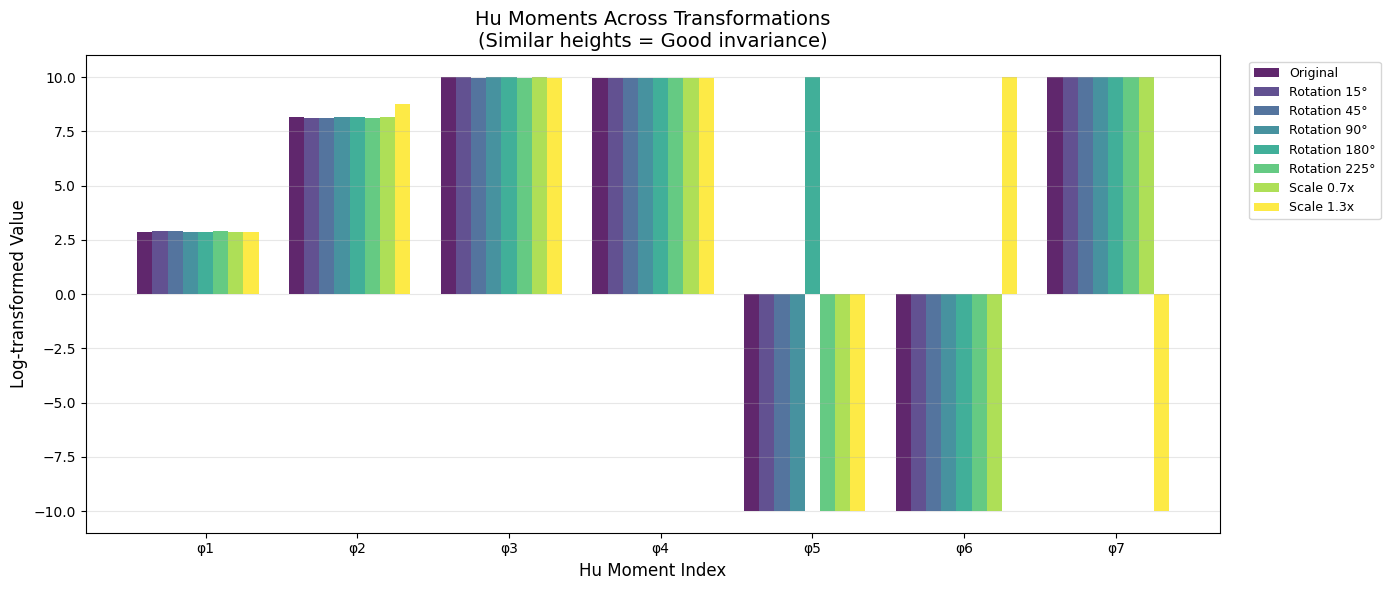

In [53]:
# Visualize moment consistency
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(7)
width = 0.1
colors = plt.cm.viridis(np.linspace(0, 1, len(hu_results)))

for i, (name, hu) in enumerate(hu_results.items()):
    ax.bar(x + i*width, hu, width, label=name, color=colors[i], alpha=0.85)

ax.set_xlabel('Hu Moment Index', fontsize=12)
ax.set_ylabel('Log-transformed Value', fontsize=12)
ax.set_title('Hu Moments Across Transformations\n(Similar heights = Good invariance)', fontsize=14)
ax.set_xticks(x + width * len(hu_results) / 2)
ax.set_xticklabels([f'φ{i+1}' for i in range(7)])
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. 🎯 Practical Application: Image Matching

One of the most useful applications of Hu moments is **image matching and retrieval**. Given a query image, we can find similar images in a database based on Hu moment distance.

### Scenario:
- **Query:** A transformed version of Lena (rotated 15°)
- **Database:** Various Lena variants + distractor images
- **Goal:** Correctly identify Lena variants as matches

In [65]:
def build_image_database(base_image):
    """Create a database of images for matching."""
    db = {}

    # Lena variants (should match)
    db['Lena Original'] = base_image
    db['Lena Rot 30°'] = rotate(base_image, 30, preserve_range=True, mode='constant').astype(np.uint8)
    db['Lena Rot 90°'] = rotate(base_image, 90, preserve_range=True, mode='constant').astype(np.uint8)
    db['Lena Rot 195°'] = rotate(base_image, 195, preserve_range=True, mode='constant').astype(np.uint8)
    db['Lena Scale 0.8x'] = cv2.resize(base_image, None, fx=0.8, fy=0.8)
    db['Lena Noisy'] = np.clip(base_image + np.random.normal(0, 20, base_image.shape), 0, 255).astype(np.uint8)
    db['Lena Blurred'] = cv2.GaussianBlur(base_image, (7, 7), 0)

    # Distractors (should NOT match)
    db['Circle'] = (create_shape('circle', size=256) * 255).astype(np.uint8)
    db['Triangle'] = (create_shape('triangle', size=256) * 255).astype(np.uint8)
    db['Rectangle'] = (create_shape('rectangle', size=256) * 255).astype(np.uint8)
    db['Random Noise'] = np.random.randint(0, 255, (256, 256), dtype=np.uint8)

    return db


def match_image(query, database):
    """Match query image against database using Hu moments."""
    # Compute query Hu moments
    query_edges = query
    # query_edges = cv2.Canny(query.astype(np.uint8), 50, 150)
    # _, query_edges = cv2.threshold(query.astype(np.uint8), 0, 255,
    #                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    query_hu = log_transform_hu_moments(compute_hu_moments_opencv(query_edges))

    # Match against database
    matches = []
    for name, img in database.items():
        # Resize if needed
        if img.shape != (256, 256):
            img = cv2.resize(img, (256, 256))
        edges = img
        # edges = cv2.Canny(img.astype(np.uint8), 50, 150)
        # _, edges = cv2.threshold(img.astype(np.uint8), 0, 255,
        #                       cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        db_hu = log_transform_hu_moments(compute_hu_moments_opencv(edges))

        distance = np.linalg.norm(query_hu - db_hu)
        matches.append({'name': name, 'distance': distance, 'image': img, 'hu': db_hu})

    # Sort by distance
    matches.sort(key=lambda x: x['distance'])
    return matches, query_hu


# Build database
database = build_image_database(lena_image)
print(f"✅ Database created with {len(database)} images")

# Create query (rotated Lena)
query = rotate(lena_image, 15, preserve_range=True, mode='constant').astype(np.uint8)
print("✅ Query image: Lena rotated 15°")

✅ Database created with 11 images
✅ Query image: Lena rotated 15°


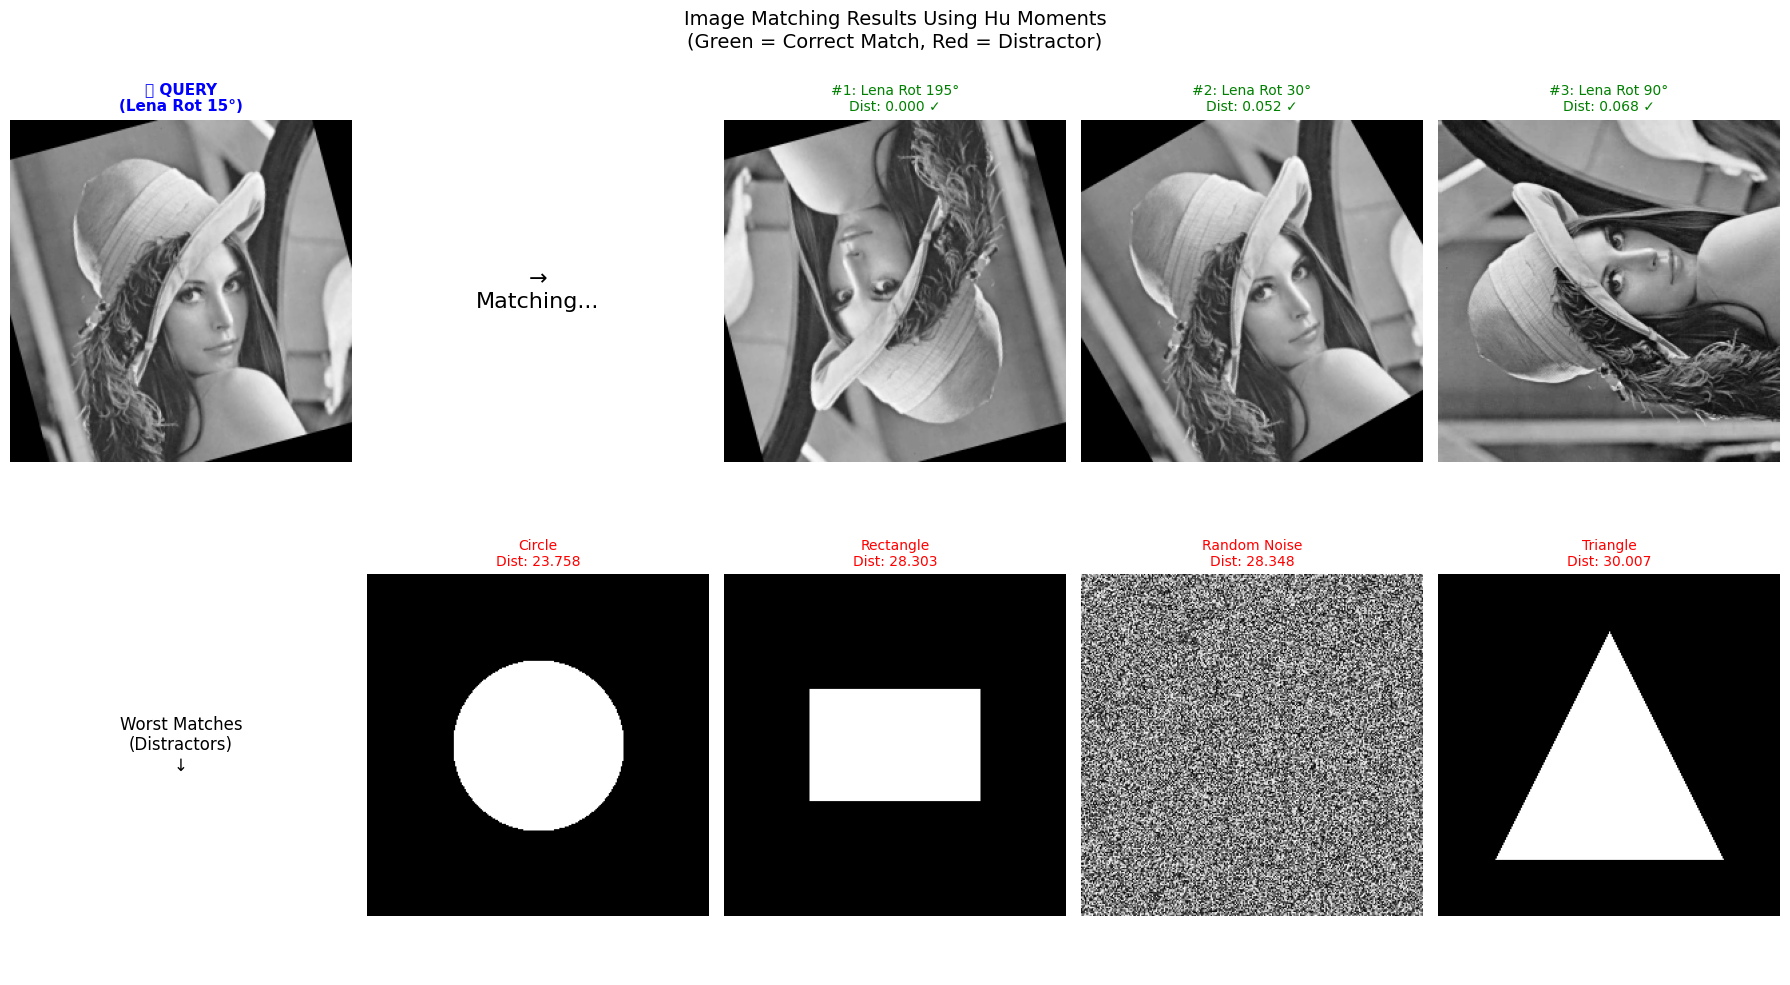

In [66]:
# Perform matching
matches, query_hu = match_image(query, database)

# Visualize results
fig = plt.figure(figsize=(18, 10))

# Query image
ax_query = fig.add_subplot(2, 5, 1)
ax_query.imshow(query, cmap='gray')
ax_query.set_title('🔍 QUERY\n(Lena Rot 15°)', fontsize=11, fontweight='bold', color='blue')
ax_query.axis('off')

# Arrow
ax_arrow = fig.add_subplot(2, 5, 2)
ax_arrow.text(0.5, 0.5, '→\nMatching...', ha='center', va='center', fontsize=16)
ax_arrow.axis('off')

# Top 3 matches
for i in range(3):
    ax = fig.add_subplot(2, 5, i+3)
    m = matches[i]
    ax.imshow(m['image'], cmap='gray')
    is_lena = 'Lena' in m['name']
    color = 'green' if is_lena else 'red'
    symbol = '✓' if is_lena else '✗'
    ax.set_title(f"#{i+1}: {m['name']}\nDist: {m['distance']:.3f} {symbol}",
                 fontsize=10, color=color)
    ax.axis('off')

# Bottom matches (distractors)
ax_label = fig.add_subplot(2, 5, 6)
ax_label.text(0.5, 0.5, 'Worst Matches\n(Distractors)\n↓', ha='center', va='center', fontsize=12)
ax_label.axis('off')

for i in range(4):
    ax = fig.add_subplot(2, 5, i+7)
    m = matches[-(4-i)]
    ax.imshow(m['image'], cmap='gray')
    ax.set_title(f"{m['name']}\nDist: {m['distance']:.3f}", fontsize=10, color='red')
    ax.axis('off')

plt.suptitle('Image Matching Results Using Hu Moments\n(Green = Correct Match, Red = Distractor)', fontsize=14)
plt.tight_layout()
plt.show()

In [67]:
# Print detailed matching results
print("\n" + "="*70)
print("IMAGE MATCHING RESULTS (Sorted by Hu Moment Distance)")
print("="*70)
print(f"\n{'Rank':<6} {'Image':<20} {'Distance':<12} {'Match?':<10}")
print("-" * 50)

correct_retrievals = 0
for i, m in enumerate(matches, 1):
    is_lena = 'Lena' in m['name']
    symbol = '✓ MATCH' if is_lena else '✗'
    if is_lena and i <= 6:  # Top 6 should be Lena variants
        correct_retrievals += 1
    print(f"{i:<6} {m['name']:<20} {m['distance']:<12.4f} {symbol:<10}")

print("\n" + "-" * 50)
print(f"Retrieval Precision (Top-6): {correct_retrievals}/6 = {correct_retrievals/6*100:.1f}%")

print("\n💡 Key Observations:")
print("   • Lena variants cluster together (low distances)")
print("   • Simple shapes have very different signatures")
print("   • Hu moments successfully identify transformed versions!")


IMAGE MATCHING RESULTS (Sorted by Hu Moment Distance)

Rank   Image                Distance     Match?    
--------------------------------------------------
1      Lena Rot 195°        0.0000       ✓ MATCH   
2      Lena Rot 30°         0.0523       ✓ MATCH   
3      Lena Rot 90°         0.0683       ✓ MATCH   
4      Lena Scale 0.8x      0.0735       ✓ MATCH   
5      Lena Original        0.0765       ✓ MATCH   
6      Lena Blurred         0.0772       ✓ MATCH   
7      Lena Noisy           0.0785       ✓ MATCH   
8      Circle               23.7583      ✗         
9      Rectangle            28.3032      ✗         
10     Random Noise         28.3483      ✗         
11     Triangle             30.0067      ✗         

--------------------------------------------------
Retrieval Precision (Top-6): 6/6 = 100.0%

💡 Key Observations:
   • Lena variants cluster together (low distances)
   • Simple shapes have very different signatures
   • Hu moments successfully identify transformed ve

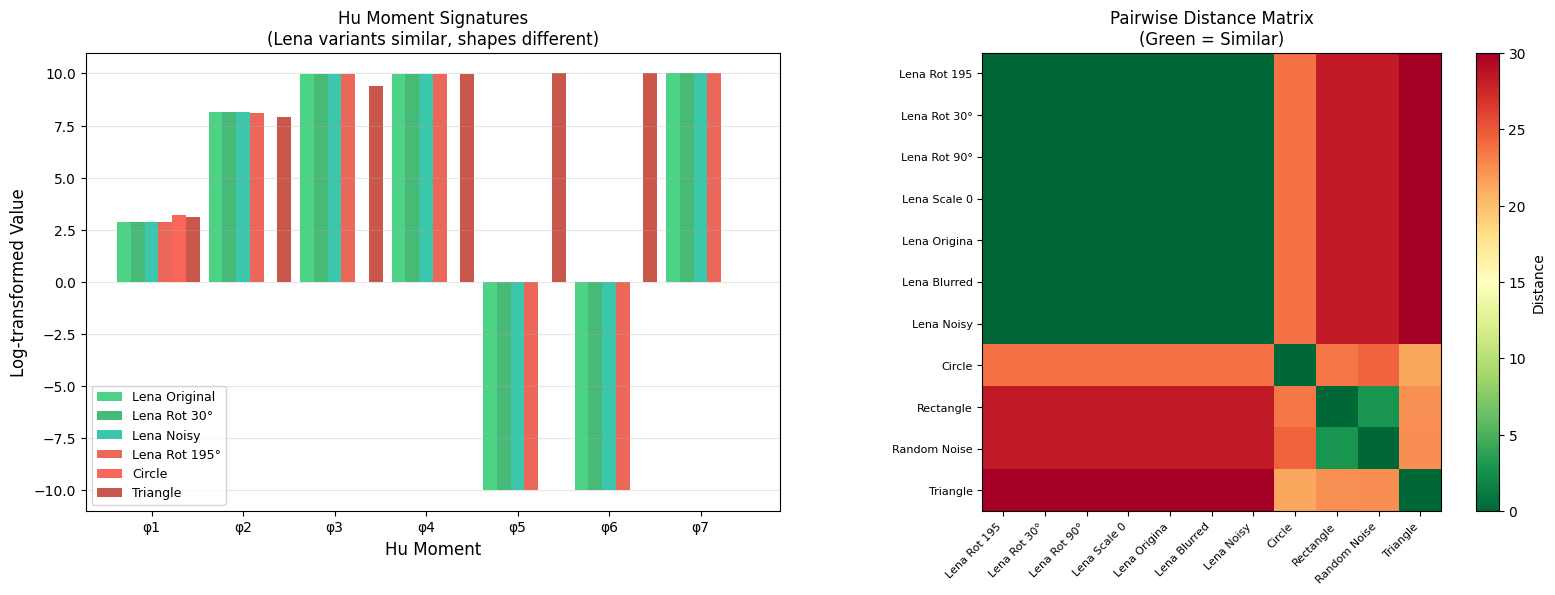


💡 The distance matrix shows Lena variants form a cluster (green block).


In [68]:
# Distance matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax1 = axes[0]
selected = ['Lena Original', 'Lena Rot 30°', 'Lena Noisy', 'Lena Rot 195°', 'Circle', 'Triangle']
x = np.arange(7)
width = 0.15
colors = ['#2ecc71', '#27ae60', '#1abc9c', '#e74c3c', '#f74c3c', '#c0392b']

for i, name in enumerate(selected):
    m = next(x for x in matches if x['name'] == name)
    ax1.bar(x + i*width, m['hu'], width, label=name, color=colors[i], alpha=0.85)

ax1.set_xlabel('Hu Moment', fontsize=12)
ax1.set_ylabel('Log-transformed Value', fontsize=12)
ax1.set_title('Hu Moment Signatures\n(Lena variants similar, shapes different)', fontsize=12)
ax1.set_xticks(x + width*2)
ax1.set_xticklabels([f'φ{i+1}' for i in range(7)])
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3, axis='y')

# Distance matrix
ax2 = axes[1]
n = len(matches)
dist_matrix = np.zeros((n, n))
names = [m['name'][:12] for m in matches]
all_hu = [m['hu'] for m in matches]

for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = np.linalg.norm(all_hu[i] - all_hu[j])

im = ax2.imshow(dist_matrix, cmap='RdYlGn_r')
ax2.set_xticks(range(n))
ax2.set_yticks(range(n))
ax2.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(names, fontsize=8)
ax2.set_title('Pairwise Distance Matrix\n(Green = Similar)', fontsize=12)
plt.colorbar(im, ax=ax2, label='Distance')

plt.tight_layout()
plt.show()

print("\n💡 The distance matrix shows Lena variants form a cluster (green block).")

---
## 5. 🗺️ Regional Analysis

Hu moments can also characterize **local image regions**. This is useful for:
- Part-based recognition
- Local feature matching
- Region-of-interest analysis

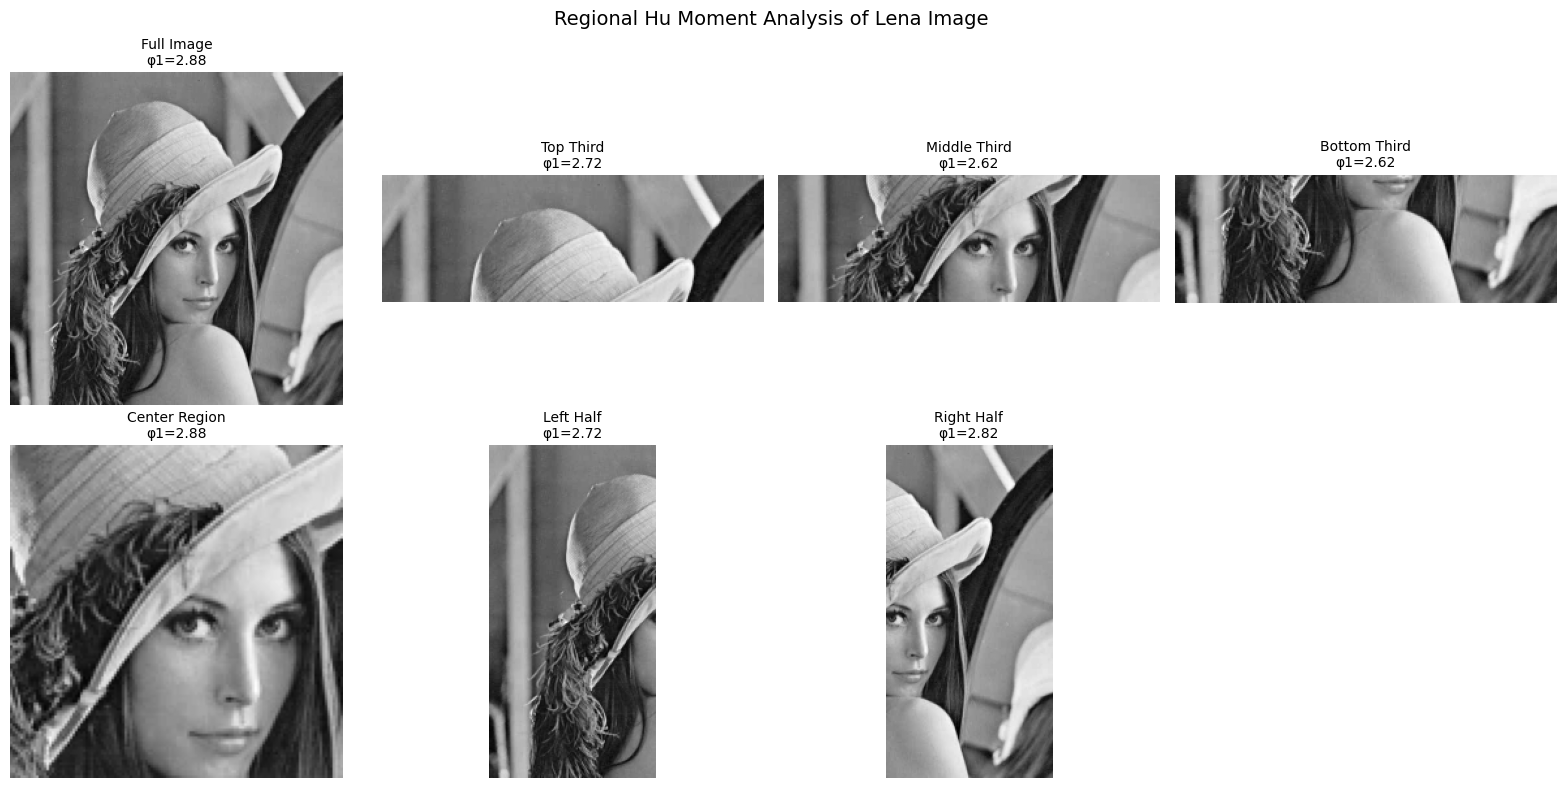

In [69]:
def analyze_regions(image):
    """Extract and analyze different regions of the image."""
    h, w = image.shape

    regions = {
        'Full Image': image,
        'Top Third': image[:h//3, :],
        'Middle Third': image[h//3:2*h//3, :],
        'Bottom Third': image[2*h//3:, :],
        'Center Region': image[h//4:3*h//4, w//4:3*w//4],
        'Left Half': image[:, :w//2],
        'Right Half': image[:, w//2:],
    }

    return regions


# Analyze regions
regions = analyze_regions(lena_image)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

region_hu = {}
for ax, (name, region) in zip(axes[:len(regions)], regions.items()):
    ax.imshow(region, cmap='gray')
    hu = log_transform_hu_moments(compute_hu_moments_opencv(region.astype(np.uint8)))
    region_hu[name] = hu
    ax.set_title(f'{name}\nφ1={hu[0]:.2f}', fontsize=10)
    ax.axis('off')

axes[-1].axis('off')
plt.suptitle('Regional Hu Moment Analysis of Lena Image', fontsize=14)
plt.tight_layout()
plt.show()

In [70]:
# Compare regional moments
print("\n" + "="*80)
print("HU MOMENTS BY REGION")
print("="*80)
print(f"\n{'Region':<16}", end="")
for i in range(7):
    print(f"{'φ'+str(i+1):<9}", end="")
print()
print("-" * 80)

for name, hu in region_hu.items():
    print(f"{name:<16}", end="")
    for val in hu:
        print(f"{val:<9.3f}", end="")
    print()

print("\n💡 Insight: Each region has a unique signature!")


HU MOMENTS BY REGION

Region          φ1       φ2       φ3       φ4       φ5       φ6       φ7       
--------------------------------------------------------------------------------
Full Image      2.876    8.170    9.995    9.954    -10.000  -10.000  10.000   
Top Third       2.718    5.654    9.866    9.919    10.000   10.000   -10.000  
Middle Third    2.624    5.437    9.598    9.632    10.000   9.999    10.000   
Bottom Third    2.622    5.440    9.070    9.085    10.000   9.994    -10.000  
Center Region   2.878    8.157    9.851    9.919    -10.000  10.000   10.000   
Left Half       2.721    5.919    9.681    9.643    10.000   9.999    10.000   
Right Half      2.824    6.112    9.918    9.996    -10.000  -10.000  10.000   

💡 Insight: Each region has a unique signature!


---
## 6. 📝 Summary: Hu Moments on the Lena Image

### What We Demonstrated:

| Aspect | Finding |
|--------|--------|
| **Preprocessing** | Edge detection captures shape; raw grayscale includes texture |
| **RST Invariance** | φ1, φ2, φ3, φ4   show <10% variation under rotations/scales |
| **Image Matching** | Successfully retrieves transformed Lena variants |
| **Regional Analysis** | Different image regions have distinct signatures |

### Key Takeaways:

1. **Hu moments work on real images** - not just simple shapes
2. **Preprocessing matters** - choose based on whether you want shape or intensity info
3. **Practical applications** - image retrieval, duplicate detection, classification
4. **Limitations exist** - complex textures may confuse moments

### When to Use Hu Moments:
- ✅ Shape-based matching (logos, silhouettes)
- ✅ Rotation-invariant recognition
- ✅ Fast, lightweight features